In [1]:
# Loading required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
import plotly.express as px

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sklearn.metrics as metrics
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.cluster import KMeans

%pylab inline

## Checking the VIFs to assess dependence of all X variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import Image, display
import pygraphviz
import dowhy
import statsmodels

import dice_ml


import warnings
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib


## 1. Data upload, cleaning and exploratory data analysis

In [2]:
## Load the dataset into pandas DataFrame
raw_data = pd.read_csv("hotel_bookings.csv")
raw_data.head()
raw_data.shape

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2   0.00000       0   
1                        0                     0       2   0.00000       0   
2                        0                     1       1   0.00000       0   
3                        0                     1       1   0.00000       0   
4                        0                     2       2   0.00000       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
0   BB     PRT         Direct               Direct                  0   
1   BB     PRT         Direct               Direct                  0   
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  C   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type     agent  company  \
0                  C                3   No Deposit       NaN      NaN   
1                  C                4   No Deposit       NaN      NaN   
2                  C                0   No Deposit       NaN      NaN   
3                  A                0   No Deposit 304.00000      NaN   
4                  A                0   No Deposit 240.00000      NaN   

   days_in_waiting_list customer_type      adr  required_car_parking_spaces  \
0                     0     Transient  0.00000                            0   
1                     0     Transient  0.00000                            0   
2                     0     Transient 75.00000                            0   
3                     0     Transient 75.00000                            0   
4                     0     Transient 98.00000                            0   

   total_of_special_requests reservation_status reservation_status_date  
0                          0          Check-Out              2015-07-01  
1                          0          Check-Out              2015-07-01  
2                          0          Check-Out              2015-07-02  
3                          0          Check-Out              2015-07-02  
4                          1          Check-Out              2015-07-03

In [3]:
## Checking if there are any missing values in the data
# Showing NaN value count
values_na = pd.DataFrame({'NaN_values' : raw_data.isna().sum(),'Perc' : (raw_data.isna().sum()/len(raw_data))*100})
values_na.sort_values(by='NaN_values', ascending=False, inplace=True)
values_na[values_na.NaN_values > 0]

NaN_values     Perc
company       112593 94.30689
agent          16340 13.68624
country          488  0.40874
children           4  0.00335

In [4]:
## Replace missing values:
## agent/ company not given: private booking
df = raw_data.copy()
df = df.fillna({"children": 0,"country": "Unknown", "agent": 0, "company": 0})

## Replace undefined meals as SC and Transient-Party customer_type to Transient
df["meal"].replace("Undefined", "SC", inplace=True)
df["customer_type"].replace('Transient-Party','Transient',inplace=True)

## drop records witth 0 adults, 0 children and 0 babies
zero_guests = list(df.loc[df["adults"] + df["children"] + df["babies"]==0].index)
df.drop(df.index[zero_guests], inplace=True)

In [5]:
## check cancellation rate
## ~40% of the data belongs to not joined. 
## The class is not very imbalanced and can be worked upon as is.
df['is_canceled'].value_counts(normalize = True)

0   0.62923
1   0.37077
Name: is_canceled, dtype: float64

In [6]:
## Datatype for all the variables looks not consitent with the understanding. 
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [7]:
## adjust for datatype
df['reservation_status_date'] = df['reservation_status_date'].astype('datetime64[ns]')

### 1.1. EDA - general

In [8]:
## normalize price per night (adr):
df_eda = df.copy()
df_eda["adr_pp"] = df_eda["adr"] / (df_eda["adults"] + df_eda["children"])

## adjust for datatype for eda
for i in ['arrival_date_year','is_repeated_guest','agent', 'company']:
    df_eda[i] = df_eda[i].astype('object')    

# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = df_eda.loc[(df_eda["hotel"] == "Resort Hotel") & (df_eda["is_canceled"] == 0)]
ch = df_eda.loc[(df_eda["hotel"] == "City Hotel") & (df_eda["is_canceled"] == 0)]

In [9]:
# get number of acutal guests by country
country_data = pd.DataFrame(df_eda.loc[df_eda["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")

<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='reserved_room_type', ylabel='adr_pp'>

Text(0.5, 1.0, 'Price of room types per night and person')

Text(0.5, 0, 'Room type')

Text(0, 0.5, 'Price [EUR]')

(0.0, 160.0)

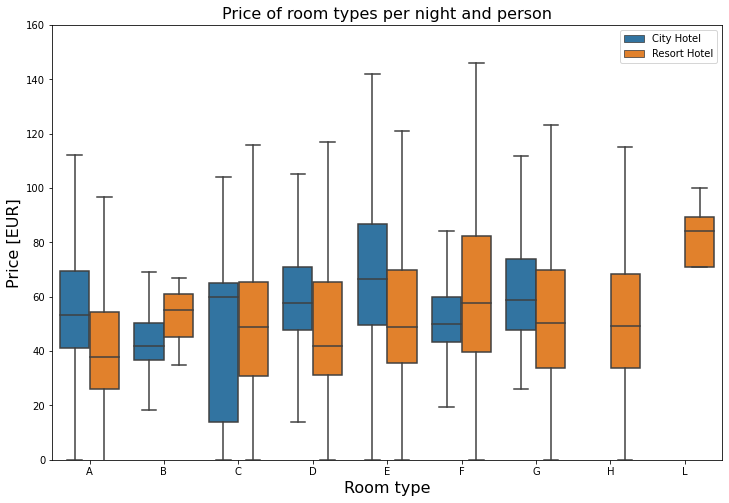

In [10]:
## How much do guests pay for a room per night?

full_data_guests = df_eda.loc[df_eda["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='arrival_date_month', ylabel='adr_pp'>

Text(0.5, 1.0, 'Room price per night and person over the year')

Text(0.5, 0, 'Month')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Price [EUR]')

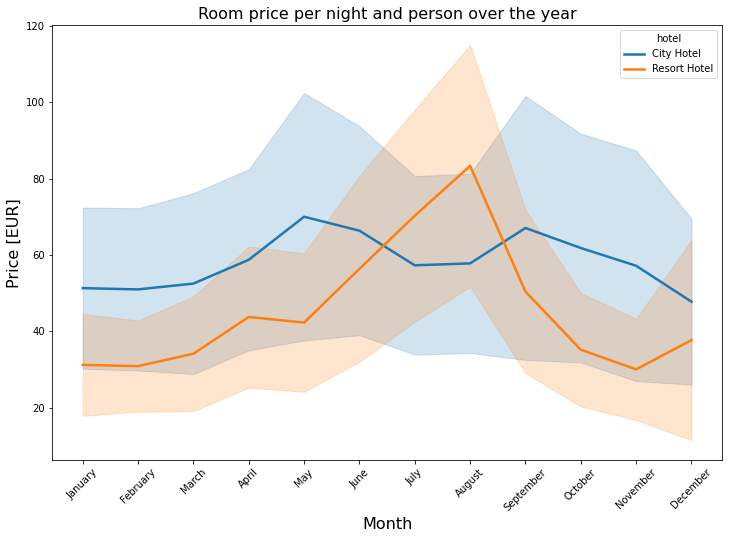

In [11]:
# grab data:
room_prices_monthly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_monthly["arrival_date_month"] = pd.Categorical(room_prices_monthly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_monthly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='month', ylabel='guests'>

Text(0.5, 1.0, 'Average number of hotel guests per month')

Text(0.5, 0, 'Month')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Number of guests')

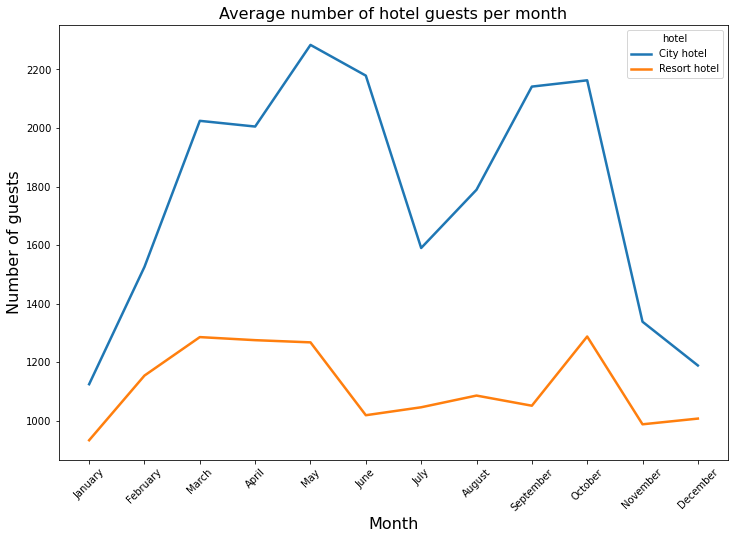

In [12]:
## Which are the most busy month?

# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

<Figure size 1152x576 with 0 Axes>

<AxesSubplot:xlabel='num_nights', ylabel='rel_num_bookings'>

Text(0.5, 1.0, 'Length of stay')

Text(0.5, 0, 'Number of nights')

Text(0, 0.5, 'Guests [%]')

(0.0, 22.0)

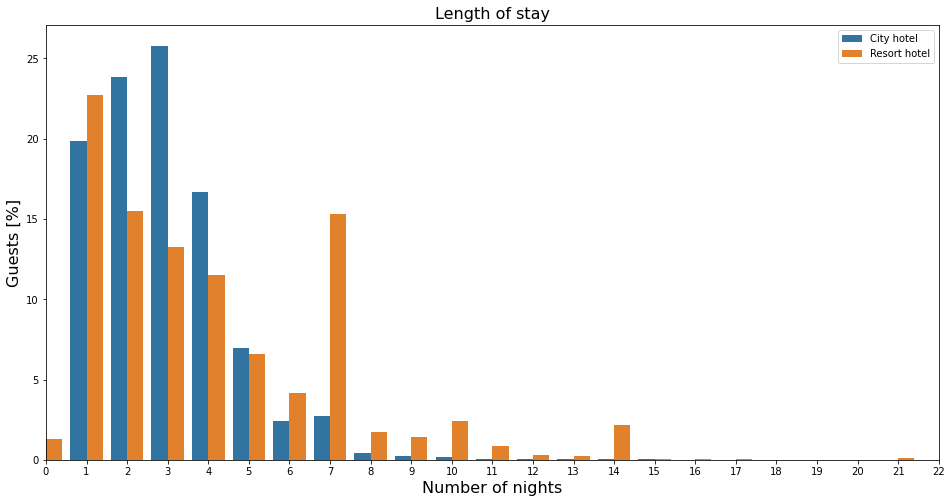

In [13]:
### How long do people stay at the hotels?

# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [10]:
## How people book hotels
# total bookings per market segment (incl. canceled)

segments=df_eda["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")

***Findings:***    
about 20% from local country
Resort hotel has much higher during the summer, City hotel has less volatility on rate
City hotel has more guests than Resort hotel, and it has more guest during spring and autumn, and low guest in summer


<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='lead_time'>

Text(0.5, 1.0, 'Effect of lead time on cancellation')

Text(0.5, 0, 'Lead time')

Text(0, 0.5, 'Cancellations [%]')

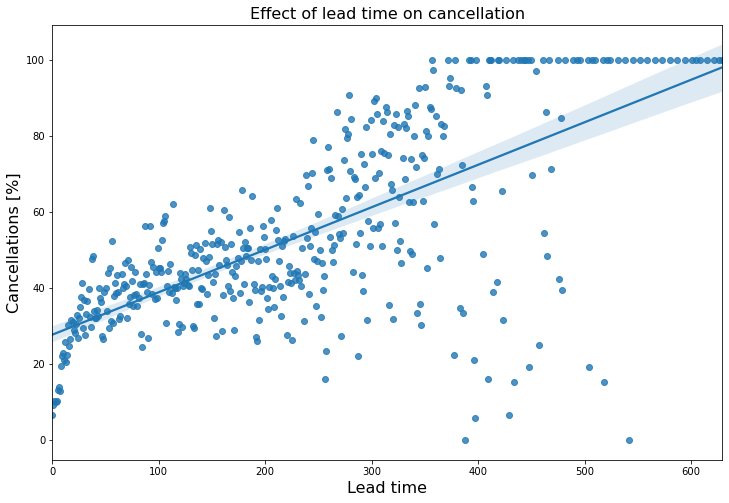

In [15]:
# group data for lead_time:
lead_cancel_data = df_eda.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancellation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancellations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

### 1.2. EDA - Interaction with the variable of interest

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='hotel'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='arrival_date_year'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='arrival_date_month'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='meal'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='country'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='market_segment'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='distribution_channel'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='is_repeated_guest'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='reserved_room_type'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='assigned_room_type'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='deposit_type'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='agent'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='company'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='customer_type'>

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='reservation_status'>

<Figure size 720x576 with 0 Axes>

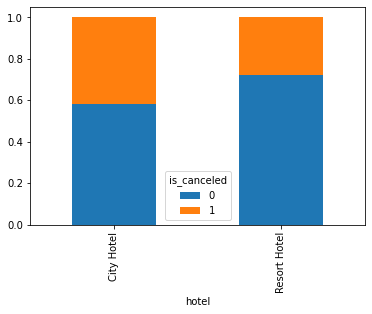

<Figure size 720x576 with 0 Axes>

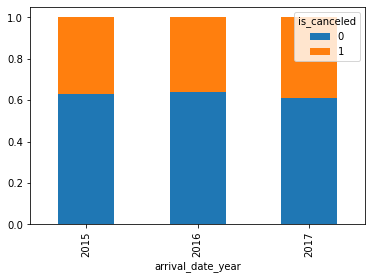

<Figure size 720x576 with 0 Axes>

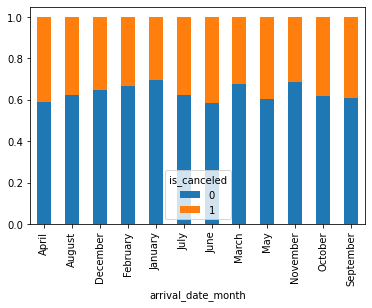

<Figure size 720x576 with 0 Axes>

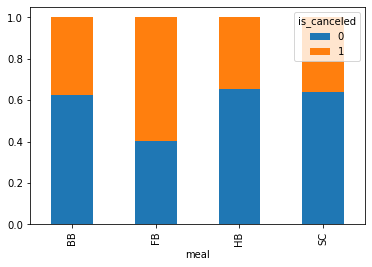

<Figure size 720x576 with 0 Axes>

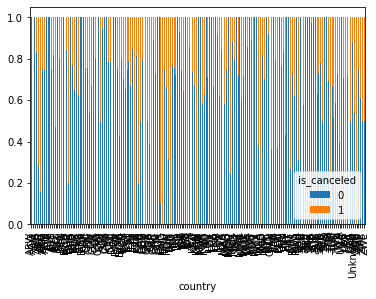

<Figure size 720x576 with 0 Axes>

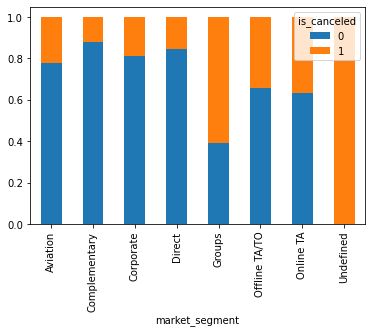

<Figure size 720x576 with 0 Axes>

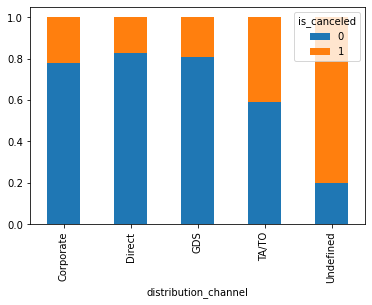

<Figure size 720x576 with 0 Axes>

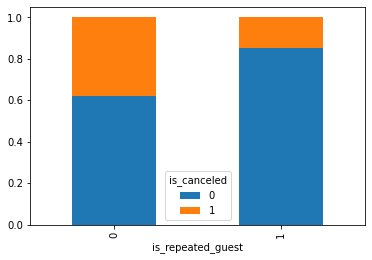

<Figure size 720x576 with 0 Axes>

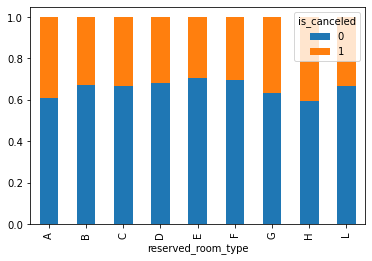

<Figure size 720x576 with 0 Axes>

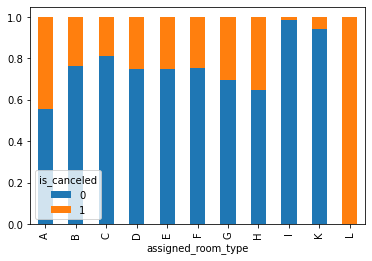

<Figure size 720x576 with 0 Axes>

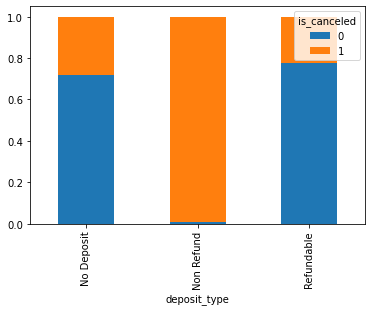

<Figure size 720x576 with 0 Axes>

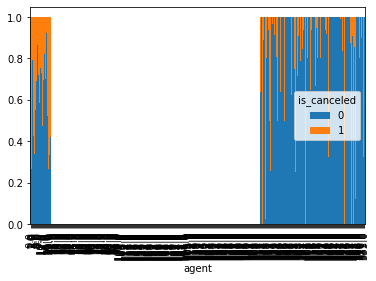

<Figure size 720x576 with 0 Axes>

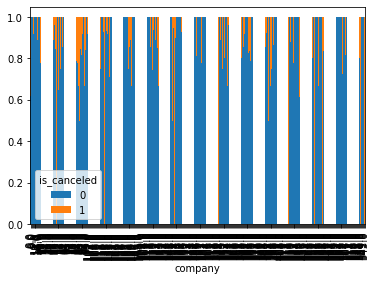

<Figure size 720x576 with 0 Axes>

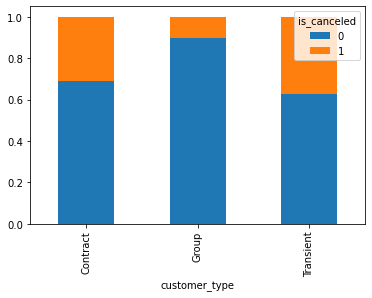

<Figure size 720x576 with 0 Axes>

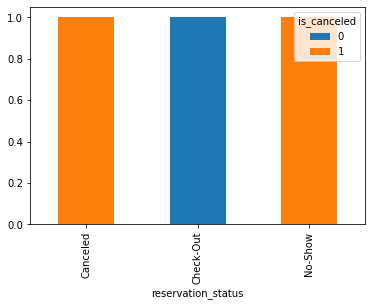

In [16]:
## Visualizing categorical variables against the variable of interest
for x in df_eda.select_dtypes(include=['object']).columns.tolist():
    plt.figure(figsize = (10,8))
    pd.crosstab(df_eda[x] , df_eda['is_canceled']  , normalize='index').plot(kind = 'bar' , stacked='True')

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='is_canceled', ylabel='Density'>

<AxesSubplot:xlabel='is_canceled', ylabel='Density'>

No handles with labels found to put in legend.


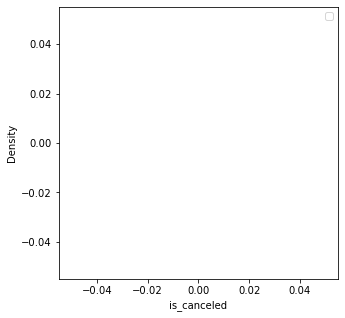

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

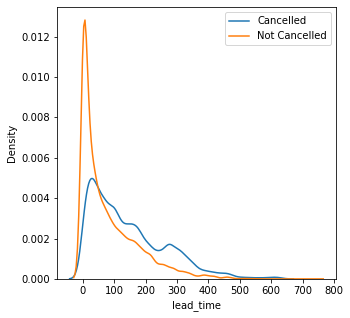

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='arrival_date_week_number', ylabel='Density'>

<AxesSubplot:xlabel='arrival_date_week_number', ylabel='Density'>

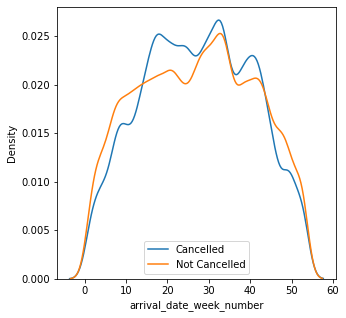

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='arrival_date_day_of_month', ylabel='Density'>

<AxesSubplot:xlabel='arrival_date_day_of_month', ylabel='Density'>

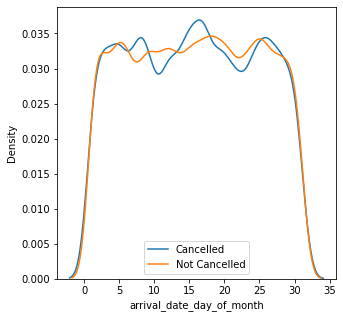

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='stays_in_weekend_nights', ylabel='Density'>

<AxesSubplot:xlabel='stays_in_weekend_nights', ylabel='Density'>

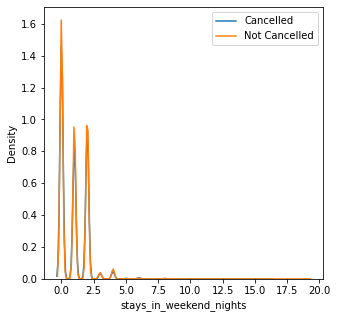

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='Density'>

<AxesSubplot:xlabel='stays_in_week_nights', ylabel='Density'>

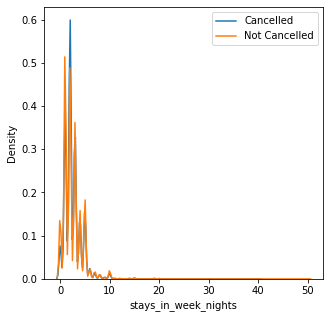

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='adults', ylabel='Density'>

<AxesSubplot:xlabel='adults', ylabel='Density'>

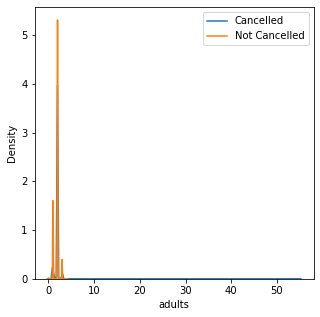

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='children', ylabel='Density'>

<AxesSubplot:xlabel='children', ylabel='Density'>

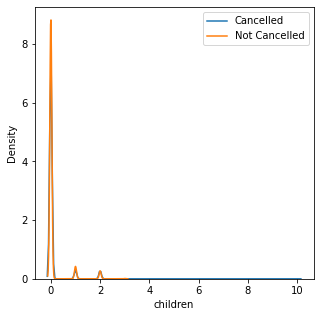

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='babies', ylabel='Density'>

<AxesSubplot:xlabel='babies', ylabel='Density'>

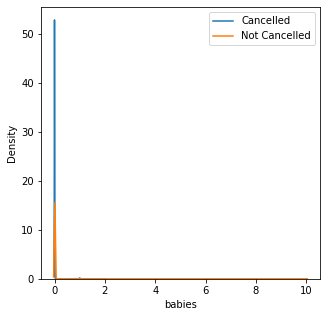

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='previous_cancellations', ylabel='Density'>

<AxesSubplot:xlabel='previous_cancellations', ylabel='Density'>

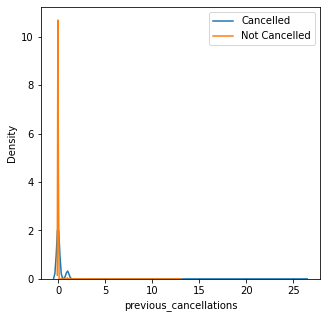

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='previous_bookings_not_canceled', ylabel='Density'>

<AxesSubplot:xlabel='previous_bookings_not_canceled', ylabel='Density'>

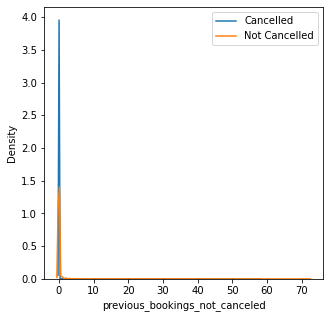

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='booking_changes', ylabel='Density'>

<AxesSubplot:xlabel='booking_changes', ylabel='Density'>

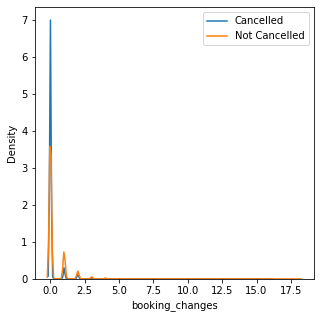

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='days_in_waiting_list', ylabel='Density'>

<AxesSubplot:xlabel='days_in_waiting_list', ylabel='Density'>

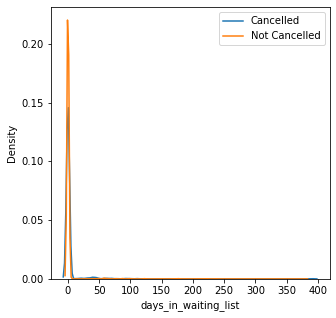

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='adr', ylabel='Density'>

<AxesSubplot:xlabel='adr', ylabel='Density'>

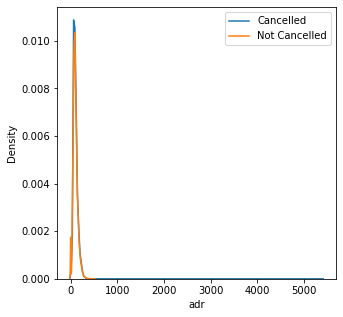

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='required_car_parking_spaces', ylabel='Density'>

<AxesSubplot:xlabel='required_car_parking_spaces', ylabel='Density'>

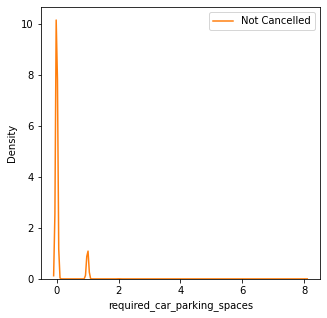

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='total_of_special_requests', ylabel='Density'>

<AxesSubplot:xlabel='total_of_special_requests', ylabel='Density'>

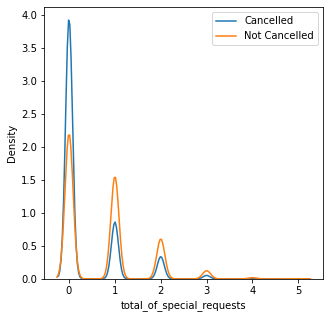

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='adr_pp', ylabel='Density'>

<AxesSubplot:xlabel='adr_pp', ylabel='Density'>

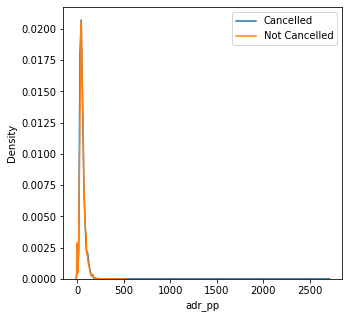

In [17]:
## Visualizing continuous variables against the variable of interest
for x in df_eda.select_dtypes(include=['number']).columns.tolist():
    plt.figure(figsize = (5,5))
    sns.kdeplot(df_eda.loc[df_eda['is_canceled']==1,x], label='Cancelled')
    sns.kdeplot(df_eda.loc[df_eda['is_canceled']==0,x], label='Not Cancelled')
    plt.legend()
    plt.show()

### 1.3. Findings

**Categorical:**  
City hotel has higher cancellation rate      
April, May, June(middle of the year) have higher cancellation rate   
FB meal has higher cancellation rate   
Group market_segment has higher cancellation rate   
TA/TO distribution_channel has higher cancellation rate   
**Non repeated_guest has significant higher cancellation rate   
Assigned room type = L(expensive room) has significant higher cancellation rate   
Deposit_type of "non refund  has dominant higher cancellation rate**   
Customer_type = Trasient or Contract has higher cancellation rate 

**Numerical:**    
Longer lead time has higher cancellation rate  
Middle of the year/month have higher cancellation rate      
Significant more number of adults and children have higher cancellation rate      
No babies has higher cancellation rate 
Higer previouscancellations has higher cancellation rate   
No previous bookings not canceled(new client with no history) has higher cancellation rate  
Fewer booking changes or special requests and no required car parking spaces have higher cancellation rate   
Higher rate/higher rate per pplhas higher cancellation rate 

**All these findings make sense except non-refund cancellation**

## 2. Feature Enginieering/Encoding the variables

In [18]:
## Data cleaning

## create new meaningful feature
df['same_room'] = df['reserved_room_type'] == df['assigned_room_type']
df['total_guest'] = df['adults']+df['children']+df['babies']
df['total_night'] = df['stays_in_weekend_nights']+df['stays_in_week_nights']

# Keep a copy of the main dataset
df_main = df.copy()


## drop variables
## agent, country and company are catagorical, but has hundreds of possible values,
## and would drown out our other features if one-hot-encoded
## reservation_status basiclly the same thing as is cancelled
## 'arrival_date_week_number' same info as month
## date of month to many values
## 'distribution_channel' same thing as market sagment

df = df.drop(labels = ['agent','country','company','reservation_status',
                       'arrival_date_week_number','arrival_date_day_of_month','arrival_date_year', 
                       'assigned_room_type','same_room', 'reservation_status', 'distribution_channel'], axis=1)

## reset index
df.reset_index(inplace =True, drop =True)

df['year'] = df['reservation_status_date'].dt.year
df['month'] = df['reservation_status_date'].dt.month

df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

In [19]:
# Convert binary values to 0 and 1
def convert_to_binary(column):
    unique_vals = column.unique()
    if len(unique_vals) != 2: #this function is only for columns with 2 possible values
        print('This column has more than 2 values')
        return column
    encoded_vals = []
    for val in column:
        if val == unique_vals[0]:
            encoded_vals.append(0)
        elif val == unique_vals[1]:
            encoded_vals.append(1)
    return encoded_vals
## 0 is resort hotel
df['hotel'] = convert_to_binary(df['hotel'])
#df_new['same_room'] = convert_to_binary(df_new['same_room'])

In [20]:
# Keeping a copy of transformed data
df_orig=df.copy()

In [21]:
## lognormalize numerical values
columns_to_lognormalize=['lead_time','stays_in_weekend_nights','stays_in_week_nights','adults',
                         'children','babies','previous_cancellations',
                         'previous_bookings_not_canceled','booking_changes',
                         'days_in_waiting_list','adr','required_car_parking_spaces',
                         'total_of_special_requests','total_guest','total_night']
pt = PowerTransformer()
df[columns_to_lognormalize] = pd.DataFrame(pt.fit_transform(df[columns_to_lognormalize]), columns=columns_to_lognormalize)

In [22]:
# One hot encode categorical columns
df['year'] = df['year'].astype('object')
df['month'] = df['month'].astype('object')
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    encoded = pd.get_dummies(df[col],prefix = str(col), drop_first=True)
    df = df.join(encoded)
    df = df.drop(col, axis=1)
df.head(5)
df.shape

hotel  is_canceled  lead_time  stays_in_weekend_nights  \
0      0            0    1.59531                 -1.07621   
1      0            0    2.60640                 -1.07621   
2      0            0   -1.17639                 -1.07621   
3      0            0   -0.92226                 -1.07621   
4      0            0   -0.88812                 -1.07621   

   stays_in_week_nights   adults  children   babies  is_repeated_guest  \
0              -2.19306  0.32154  -0.27866 -0.08805                  0   
1              -2.19306  0.32154  -0.27866 -0.08805                  0   
2              -0.87764 -1.77579  -0.27866 -0.08805                  0   
3              -0.87764 -1.77579  -0.27866 -0.08805                  0   
4              -0.07818  0.32154  -0.27866 -0.08805                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                -0.23974                        -0.17679          2.38285   
1                -0.23974                        -0.17679          2.38291   
2                -0.23974                        -0.17679         -0.42142   
3                -0.23974                        -0.17679         -0.42142   
4                -0.23974                        -0.17679         -0.42142   

   days_in_waiting_list      adr  required_car_parking_spaces  \
0              -0.17880 -3.20949                     -0.25743   
1              -0.17880 -3.20949                     -0.25743   
2              -0.17880 -0.48784                     -0.25743   
3              -0.17880 -0.48784                     -0.25743   
4              -0.17880  0.01624                     -0.25743   

   total_of_special_requests  total_guest  total_night  meal_FB  meal_HB  \
0                   -0.82633      0.15848     -3.32423        0        0   
1                   -0.82633      0.15848     -3.32423        0        0   
2                   -0.82633     -1.72192     -1.47171        0        0   
3                   -0.82633     -1.72192     -1.47171        0        0   
4                    1.02714      0.15848     -0.52025        0        0   

   meal_SC  market_segment_Complementary  market_segment_Corporate  \
0        0                             0                         0   
1        0                             0                         0   
2        0                             0                         0   
3        0                             0                         1   
4        0                             0                         0   

   market_segment_Direct  market_segment_Groups  market_segment_Offline TA/TO  \
0                      1                      0                             0   
1                      1                      0                             0   
2                      1                      0                             0   
3                      0                      0                             0   
4                      0                      0                             0   

   market_segment_Online TA  market_segment_Undefined  reserved_room_type_B  \
0                         0                         0                     0   
1                         0                         0                     0   
2                         0                         0                     0   
3                         0                         0                     0   
4                         1                         0                     0   

   reserved_room_type_C  reserved_room_type_D  reserved_room_type_E  \
0                     1                     0                     0   
1                     1                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   reserved_room_type_F  reserved_room_type_G  reserved_room_typ

(119210, 54)

In [23]:
# Keeping a copy of log transformed data
df_orig_log=df.copy()

In [24]:
df_new = df.copy()

In [25]:
df_new

hotel  is_canceled  lead_time  stays_in_weekend_nights  \
0           0            0    1.59531                 -1.07621   
1           0            0    2.60640                 -1.07621   
2           0            0   -1.17639                 -1.07621   
3           0            0   -0.92226                 -1.07621   
4           0            0   -0.88812                 -1.07621   
...       ...          ...        ...                      ...   
119205      1            0   -0.63744                  1.12587   
119206      1            0    0.38229                  1.12587   
119207      1            0   -0.41129                  1.12587   
119208      1            0    0.43870                  1.12587   
119209      1            0    1.03173                  1.12587   

        stays_in_week_nights   adults  children   babies  is_repeated_guest  \
0                   -2.19306  0.32154  -0.27866 -0.08805                  0   
1                   -2.19306  0.32154  -0.27866 -0.08805                  0   
2                   -0.87764 -1.77579  -0.27866 -0.08805                  0   
3                   -0.87764 -1.77579  -0.27866 -0.08805                  0   
4                   -0.07818  0.32154  -0.27866 -0.08805                  0   
...                      ...      ...       ...      ...                ...   
119205               1.34198  0.32154  -0.27866 -0.08805                  0   
119206               1.34198  2.03000  -0.27866 -0.08805                  0   
119207               1.34198  0.32154  -0.27866 -0.08805                  0   
119208               1.34198  0.32154  -0.27866 -0.08805                  0   
119209               1.95186  0.32154  -0.27866 -0.08805                  0   

        previous_cancellations  previous_bookings_not_canceled  \
0                     -0.23974                        -0.17679   
1                     -0.23974                        -0.17679   
2                     -0.23974                        -0.17679   
3                     -0.23974                        -0.17679   
4                     -0.23974                        -0.17679   
...                        ...                             ...   
119205                -0.23974                        -0.17679   
119206                -0.23974                        -0.17679   
119207                -0.23974                        -0.17679   
119208                -0.23974                        -0.17679   
119209                -0.23974                        -0.17679   

        booking_changes  days_in_waiting_list      adr  \
0               2.38285              -0.17880 -3.20949   
1               2.38291              -0.17880 -3.20949   
2              -0.42142              -0.17880 -0.48784   
3              -0.42142              -0.17880 -0.48784   
4              -0.42142              -0.17880  0.01624   
...                 ...                   ...      ...   
119205         -0.42142              -0.17880 -0.02264   
119206         -0.42142              -0.17880  2.22264   
119207         -0.42142              -0.17880  1.14028   
119208         -0.42142              -0.17880  0.14781   
119209         -0.42142              -0.17880  1.02721   

        required_car_parking_spaces  total_of_special_requests  total_guest  \
0                          -0.25743                   -0.82633      0.15848   
1                          -0.25743                   -0.82633      0.15848   
2                          -0.25743                   -0.82633     -1.72192   
3                          -0.25743                   -0.82633     -1.72192   
4                          -0.25743                    1.02714      0.15848   
...                             ...                        ...          ...   
119205                     -0.25743                   -0.82633      0.15848   
119206                     -0.25743                    1.47583      1.47618   
119207                     -0.25743                    1.75648   

### 2.1. Check correlation

In [26]:
df_new.corrwith(df['is_canceled']).sort_values(ascending = False)

is_canceled                       1.00000
deposit_type_Non Refund           0.48151
lead_time                         0.32405
previous_cancellations            0.27102
market_segment_Groups             0.22199
hotel                             0.13708
days_in_waiting_list              0.09921
year_2015                         0.09536
adults                            0.06607
adr                               0.06119
month_12                          0.05674
total_guest                       0.05576
month_2                           0.05379
total_night                       0.05242
stays_in_week_nights              0.04789
meal_FB                           0.03879
customer_type_Transient           0.03613
reserved_room_type_H              0.00544
market_segment_Undefined          0.00534
month_11                          0.00429
month_3                           0.00211
month_10                          0.00110
year_2016                         0.00063
reserved_room_type_L             -

__Interpretation__:If we consider only the numerical values, lead time has the highest correlation with cancelled booking. Lead time is the number of days that elapsed between the entering date of the booking into the PMS and the arrival date. So the higher the lead time, higher the chance of cancellation.
<br>
total_of_special_requests and required_car_parking_spaces have the lowest correlation. It makes sense, if you have high number of special requests, the lower the chance of cancelling.

### 2.2. VIF: To check interdependence of X variables

In [27]:
## Checking the VIFs to assess dependence of all X variables
## Now, we have a lot of variabls, we will need to select important features

df2 = df_new.select_dtypes(include=['number'])

vif_df_int = df2.drop(['is_canceled','total_night'], axis = 1)
## Creating and storing in a dataframe
vif_df = pd.DataFrame({ 'columns': vif_df_int.columns,
                          'VIF': [variance_inflation_factor(vif_df_int.to_numpy() , i) for i in range(len(vif_df_int.columns))]
                      })

correlated_features = vif_df.loc[vif_df['VIF']>4, 'columns'].tolist()

vif_df.sort_values('VIF' , ascending= False).head(10)

columns       VIF
39                     year_2016 159.46318
24      market_segment_Online TA 152.15728
40                     year_2017 100.85465
38                     year_2015  68.77409
23  market_segment_Offline TA/TO  65.53202
22         market_segment_Groups  53.68016
21         market_segment_Direct  34.59818
37       customer_type_Transient  31.78228
15                   total_guest  28.07939
4                         adults  19.51567

In [28]:
correlated_features

['hotel',
 'adults',
 'children',
 'total_guest',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'customer_type_Transient',
 'year_2015',
 'year_2016',
 'year_2017']

In [29]:
## drop correlated columns
drop_cols = ['stays_in_weekend_nights','stays_in_week_nights','adults','children','babies']
df_new = df_new.drop(drop_cols, axis = 1)

## 3. Modeling

In [31]:
df_new

hotel  is_canceled  lead_time  is_repeated_guest  \
0           0            0    1.59531                  0   
1           0            0    2.60640                  0   
2           0            0   -1.17639                  0   
3           0            0   -0.92226                  0   
4           0            0   -0.88812                  0   
...       ...          ...        ...                ...   
119205      1            0   -0.63744                  0   
119206      1            0    0.38229                  0   
119207      1            0   -0.41129                  0   
119208      1            0    0.43870                  0   
119209      1            0    1.03173                  0   

        previous_cancellations  previous_bookings_not_canceled  \
0                     -0.23974                        -0.17679   
1                     -0.23974                        -0.17679   
2                     -0.23974                        -0.17679   
3                     -0.23974                        -0.17679   
4                     -0.23974                        -0.17679   
...                        ...                             ...   
119205                -0.23974                        -0.17679   
119206                -0.23974                        -0.17679   
119207                -0.23974                        -0.17679   
119208                -0.23974                        -0.17679   
119209                -0.23974                        -0.17679   

        booking_changes  days_in_waiting_list      adr  \
0               2.38285              -0.17880 -3.20949   
1               2.38291              -0.17880 -3.20949   
2              -0.42142              -0.17880 -0.48784   
3              -0.42142              -0.17880 -0.48784   
4              -0.42142              -0.17880  0.01624   
...                 ...                   ...      ...   
119205         -0.42142              -0.17880 -0.02264   
119206         -0.42142              -0.17880  2.22264   
119207         -0.42142              -0.17880  1.14028   
119208         -0.42142              -0.17880  0.14781   
119209         -0.42142              -0.17880  1.02721   

        required_car_parking_spaces  total_of_special_requests  total_guest  \
0                          -0.25743                   -0.82633      0.15848   
1                          -0.25743                   -0.82633      0.15848   
2                          -0.25743                   -0.82633     -1.72192   
3                          -0.25743                   -0.82633     -1.72192   
4                          -0.25743                    1.02714      0.15848   
...                             ...                        ...          ...   
119205                     -0.25743                   -0.82633      0.15848   
119206                     -0.25743                    1.47583      1.47618   
119207                     -0.25743                    1.75648      0.15848   
119208                     -0.25743                   -0.82633      0.15848   
119209                     -0.25743                    1.47583      0.15848   

        total_night  meal_FB  meal_HB  meal_SC  market_segment_Complementary  \
0          -3.32423        0        0        0                             0   
1          -3.32423        0        0        0                             0   
2          -1.47171        0        0        0                             0   
3          -1.47171        0        0        0                             0   
4          -0.52025        0        0        0                             0   
...             ...      ...      ...      ...                           ...   
119205      1.43833        0        0        0                             0   
119206      1.43833        0        0        0                             0   
119207      1.43833        0        0        0                             0   
119208      1.43833        0        0        0  

In [32]:
## Splitting the data into dependent and independent variables first
y = df_new['is_canceled']
X = df_new.drop('is_canceled', axis = 1)


## Creating train and test dataframes
train_x , test_x , train_y , test_y = train_test_split(X , y, train_size = 0.7 , random_state = 12)

### 3.1. Pipeline

In [97]:
#label : classifier
classifiers = {
    'Dummy Classifier - Baseline - ': DummyClassifier(),
    'decision tree':       DecisionTreeClassifier(max_depth = 15),
    'pruned decision tree':DecisionTreeClassifier(max_depth = 12, ccp_alpha = 0.0009),
    'KNN with k=10':       KNeighborsClassifier(n_neighbors=10),
    'KNN with k=15':       KNeighborsClassifier(n_neighbors=15),
    'Gaussian NB':         GaussianNB(var_smoothing=1e-3),
    'random forest':       RandomForestClassifier(max_depth = 20),
    'random forest smaller':RandomForestClassifier(max_depth = 15),
    'xgb':                 XGBClassifier(eta = 0.4, eval_metric = 'logloss'),
    'logistic regression': LogisticRegression(C = 1)
}

In [98]:
for label, clf in classifiers.items():
    pipeline = Pipeline(steps= [('scaler', StandardScaler()),
                               ('classifier', clf),])
    scores = cross_val_score(pipeline, train_x, train_y)
    print(label, scores.mean())

Dummy Classifier - Baseline -  0.6292616876010473
decision tree 0.8444760682159842
pruned decision tree 0.811329314584245
KNN with k=10 0.8544824561809763
KNN with k=15 0.849269559377612
Gaussian NB 0.7387802702676795
random forest 0.8722781756448755
random forest smaller 0.8465253049828748
xgb 0.8800794889312072
logistic regression 0.8258055612309942


### 3.2. Grid search

In [43]:
logreg = LogisticRegression() 

param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'liblinear'],
    'random_state': [42]
}

CV_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 5).fit(train_x, train_y)
print(CV_logreg.best_params_)

{'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}


In [44]:
rf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [10, 100,500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,15,20],
    'random_state': [42]
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5).fit(train_x, train_y)
print(CV_rf.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 500, 'random_state': 42}


In [45]:
dt = DecisionTreeClassifier()

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,15,20],
    'random_state': [42]
}

CV_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv= 5).fit(train_x, train_y)
print(CV_dt.best_params_)

{'criterion': 'entropy', 'max_depth': 20, 'random_state': 42}


In [46]:
knn = KNeighborsClassifier()

k_range = list(range(3, 20))
param_grid = dict(n_neighbors=k_range)

CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5).fit(train_x, train_y)
print(CV_knn.best_params_)

{'n_neighbors': 3}


In [49]:
adb = AdaBoostClassifier() 

param_grid = { 
    'n_estimators': [10, 100,500],
    'learning_rate':[0.01, 0.1, 0.5],
    'random_state':[42]
}

CV_adb = GridSearchCV(estimator=adb, param_grid=param_grid, cv= 5).fit(train_x, train_y)
print(CV_adb.best_params_)

{'learning_rate': 0.5, 'n_estimators': 500, 'random_state': 42}


In [44]:
xgb = XGBClassifier()

param_grid = { 
    'n_estimators': [10, 50, 100,500],
    'learning_rate':[0.01, 0.1, 0.5],
    'random_state':[42],
    'tree_method': ['exact', 'approx', 'hist', 'gpu_hist'],
    'eval_metric':['mean_absolute_error', 'logloss'],
    'eta': [0.4]
}

CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv= 5).fit(train_x, train_y)
print(CV_xgb.best_params_)

[08:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[08:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[08:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[08:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[08:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[08:31:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[08:31:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:223: No vi

### 3.3. Model accuracy

In [99]:
# Logistic regression
logreg = LogisticRegression(penalty='l2', random_state=42, solver='newton-cg')
logreg.fit(train_x, train_y)
y_pred_log=logreg.predict(test_x)

print('Logistic regression training accuracy:', round((logreg.score(train_x, train_y))*100, 2), '%.')
print('Logistic regression test accuracy:', round((logreg.score(test_x, test_y))*100, 2), '%.')

# Random forest
rf = RandomForestClassifier(criterion= 'gini', max_depth=20, n_estimators=100, random_state=42)
rf.fit(train_x, train_y)
y_pred_rf=rf.predict(test_x)

print('Random forest training accuracy:', round((rf.score(train_x, train_y))*100, 2), '%.')
print('Random forest test accuracy:', round((rf.score(test_x, test_y))*100, 2), '%.')

# Decision tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)
dt.fit(train_x, train_y)
y_pred_dt=dt.predict(test_x)

print('Decision tree training accuracy:', round((dt.score(train_x, train_y))*100, 2), '%.')
print('Decision tree test accuracy:', round((dt.score(test_x, test_y))*100, 2), '%.')

#KNN:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_x, train_y)
y_pred_knn=knn.predict(test_x)

print('KNN training accuracy:', round((knn.score(train_x, train_y))*100, 2), '%.')
print('KNN test accuracy:', round((knn.score(test_x, test_y))*100, 2), '%.')

# XGBoost
xgb = XGBClassifier(eta = 0.4, eval_metric = 'logloss', learning_rate=0.5, n_estimators=500, random_state=42, tree_method='hist')
xgb.fit(train_x, train_y)
y_pred_xgb=xgb.predict(test_x)

print('XGBoost training accuracy:', round((xgb.score(train_x, train_y))*100, 2), '%.')
print('XGBoost test accuracy:', round((xgb.score(test_x, test_y))*100, 2), '%.')

# AdaBoost
adb = AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=42)
adb.fit(train_x, train_y)
y_pred_adb=adb.predict(test_x)

print('AdaBoost training accuracy:', round((adb.score(train_x, train_y))*100, 2), '%.')
print('AdaBoost test accuracy:', round((adb.score(test_x, test_y))*100, 2), '%.')

LogisticRegression(random_state=42, solver='newton-cg')

Logistic regression training accuracy: 82.62 %.
Logistic regression test accuracy: 82.99 %.


RandomForestClassifier(max_depth=20, random_state=42)

Random forest training accuracy: 90.83 %.
Random forest test accuracy: 87.5 %.


DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

Decision tree training accuracy: 90.78 %.
Decision tree test accuracy: 85.63 %.


KNeighborsClassifier(n_neighbors=3)

KNN training accuracy: 92.34 %.
KNN test accuracy: 86.53 %.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.4, eval_metric='logloss', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

XGBoost training accuracy: 96.35 %.
XGBoost test accuracy: 89.51 %.


AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=42)

AdaBoost training accuracy: 82.48 %.
AdaBoost test accuracy: 82.67 %.


In [102]:
accuracy_scores = pd.DataFrame(data=[('AdaBoost',82.48,82.67),
                                     ('Logistic Regression',82.62,82.99),
                                     ('Decision Tree',90.78,85.63),
                                     ('KNN Classifier',92.34,86.53),
                                     ('Random Forest',90.83,87.50),                                            
                                     ('XGBoost Classifier',96.35,89.51)],
                                     columns=['model', 'Training_accuracy', 'Test_accuracy'])

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Model accuracy')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'Test Accuracy')

Text(0, 82.67, '82.67')

Text(1, 82.99, '82.99')

Text(2, 85.63, '85.63')

Text(3, 86.53, '86.53')

Text(4, 87.5, '87.5')

Text(5, 89.51, '89.51')

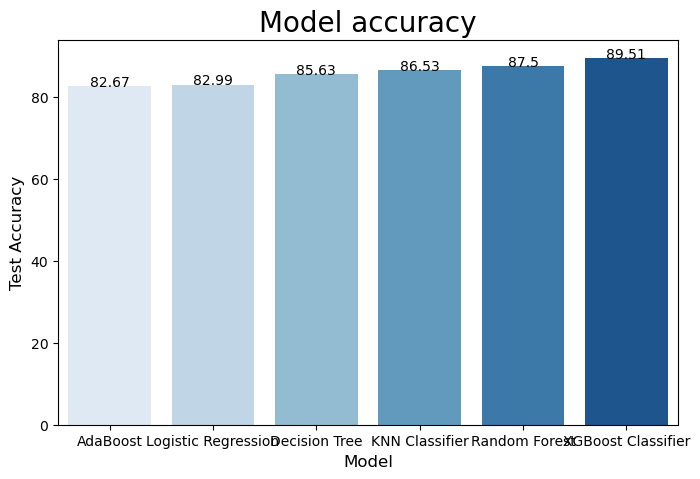

In [104]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(8,5))
p=sns.barplot(x='model', y='Test_accuracy', data=accuracy_scores, palette='Blues')
plt.title('Model accuracy', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Test Accuracy', fontsize = 12)
for index, row in accuracy_scores.iterrows():
    p.text(x=row.name, y=row.Test_accuracy, s=round(row.Test_accuracy,2), color='black', horizontalalignment='center');

XGBoost with has the highest test accuracy of 89.51 % folllowed by Random forest with 87.5% .
<br>
Logistic regression has a test accuracy of 82.99%

### 3.4. Bagging

In [ ]:
logreg = LogisticRegression(penalty='l2', random_state=42, solver='newton-cg')
rf = RandomForestClassifier(criterion= 'gini', max_depth=20, n_estimators=100, random_state=42)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)
knn = KNeighborsClassifier(n_neighbors = 3)
xgb = XGBClassifier(eta = 0.4, eval_metric = 'logloss', learning_rate=0.5, n_estimators=500, random_state=42, tree_method='hist')
adb = AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=42)

base_methods = [logreg, rf, dt, knn, xgb, adb]           
for bm  in base_methods:
    print("Method: ", bm)
    bag_model=BaggingClassifier(base_estimator=bm,n_estimators=100,bootstrap=True)
    bag_model=bag_model.fit(train_x,train_y)
    ytest_pred=bag_model.predict(test_x)
    print('Model training Score:', round((bag_model.score(train_x, train_y))*100, 2), '%.',
          'Model test Score:', round((bag_model.score(test_x, test_y))*100, 2), '%.')

Method:  LogisticRegression(random_state=42, solver='newton-cg')
Model training Score: 79.49 %. Model test Score: 79.73 %.
Method:  RandomForestClassifier(max_depth=20, random_state=42)


Method:  DecisionTreeClassifier()
<br>
Model training Score: 99.11 %. Model test Score: 85.56 %.-> Improvement(3.98)
<br>
Method:  AdaBoostClassifier()
<br>
Model training Score: 80.5 %. Model test Score: 80.51 %.-> Improvement(0.05)
<br>
Method:  XGBClassifier()
<br>
Model training Score: 85.79 %. Model test Score: 83.98 %.-> None
<br>
Method:  LogisticRegression()
<br>
Model training Score: 80.02 %. Model test Score: 80.29 %.-> Improvement(0.03)

In [ ]:
dt = DecisionTreeClassifier()
adb = AdaBoostClassifier()
xgb = XGBClassifier()
logreg = LogisticRegression()

base_methods = [dt, adb, xgb, logreg]           
for bm  in base_methods:
    print("Method: ", bm)
    bag_model=BaggingClassifier(base_estimator=bm,n_estimators=100,bootstrap=True)
    bag_model=bag_model.fit(train_x,train_y)
    ytest_pred=bag_model.predict(test_x)
    print('Model training Score:', round((bag_model.score(train_x, train_y))*100, 2), '%.',
          'Model test Score:', round((bag_model.score(test_x, test_y))*100, 2), '%.')

There was no significant change in the test accuracy of any of the models after bagging, except for Decision Tree

### 3.5. Feature Importance

In [106]:
#!pip install -q shap
#import shap

In [105]:
#explainer = shap.TreeExplainer(rfl)

In [ ]:
#shap_values = explainer.shap_values(test_x)
#shap.summary_plot(shap_values, test_x, plot_type="bar")

<BarContainer object of 12 artists>

Text(0.5, 0, 'Random Forest Feature Importance')

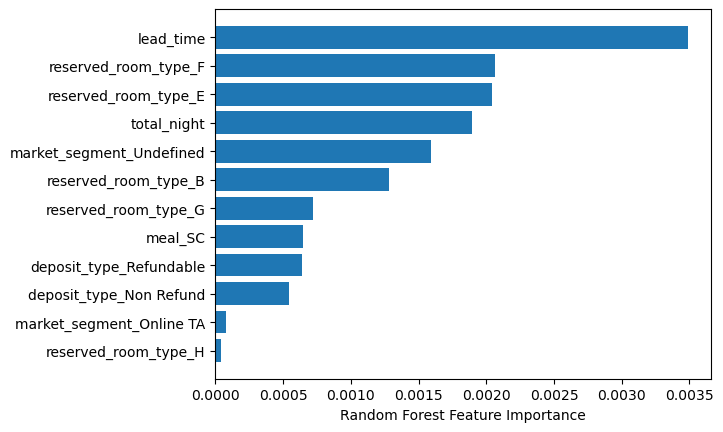

In [108]:
sorted_idx = rf.feature_importances_.argsort()[:12]
plt.barh(df_new.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

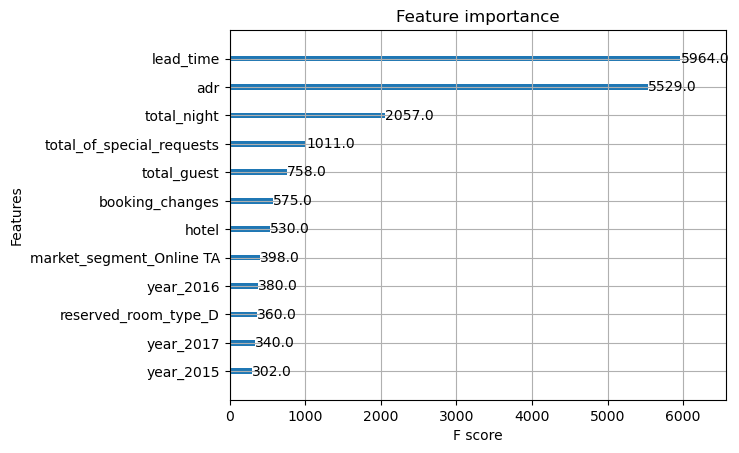

In [106]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features = 12)
pyplot.show()

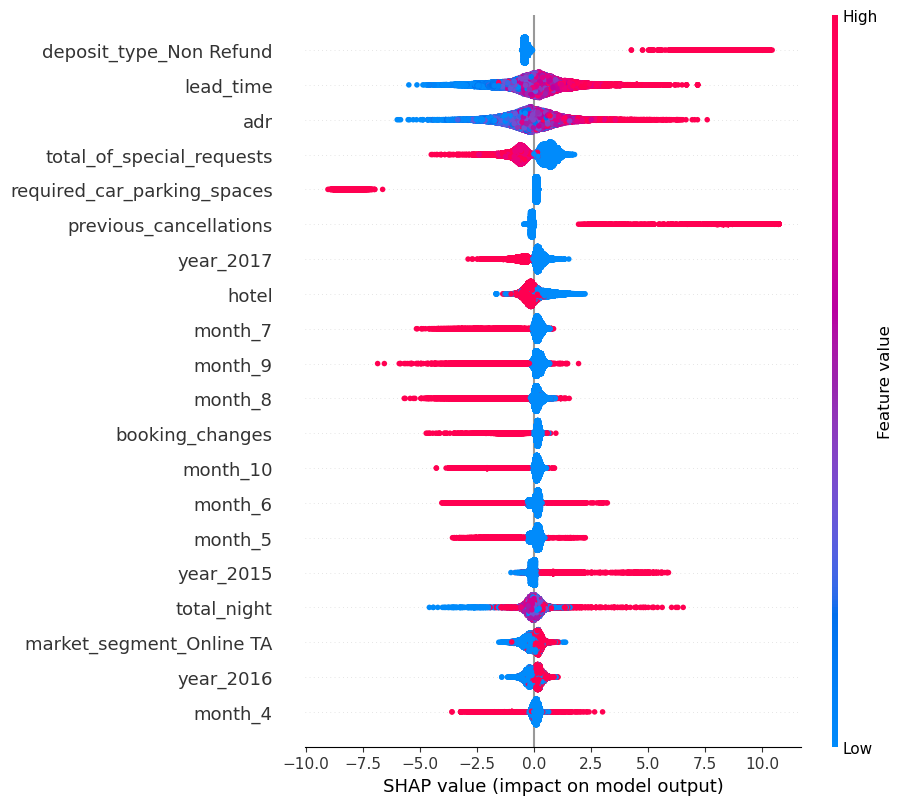

In [107]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(test_x)

shap.summary_plot(shap_values, test_x)

### 3.6. ROC Curve

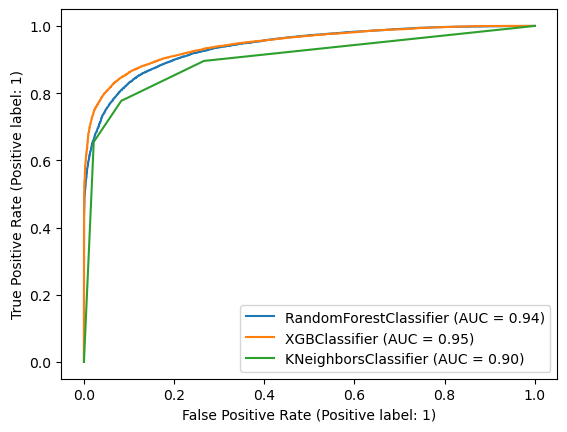

In [109]:
ax = plt.gca()
rf_disp = plot_roc_curve(rf, test_x, test_y, ax=ax)
xgb_disp = plot_roc_curve(xgb, test_x, test_y, ax=ax)
knn_disp = plot_roc_curve(knn, test_x, test_y, ax=ax)
plt.show()

### 3.7. PCA

In [110]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 3)
 
train_x_pca = pca.fit_transform(train_x)
test_x_pca = pca.transform(test_x)
 
explained_variance = pca.explained_variance_ratio_

In [111]:
# Logistic regression
logreg_pca = LogisticRegression(penalty='l2', random_state=42, solver='newton-cg')
logreg_pca.fit(train_x_pca, train_y)
y_pred_log_pca=logreg_pca.predict(test_x_pca)

print('Logistic regression training accuracy:', round((logreg_pca.score(train_x_pca, train_y))*100, 2), '%.')
print('Logistic regression test accuracy:', round((logreg_pca.score(test_x_pca, test_y))*100, 2), '%.')

# Random forest
rf_pca = RandomForestClassifier(criterion= 'gini', max_depth=20, n_estimators=100, random_state=42)
rf_pca.fit(train_x_pca, train_y)
y_pred_rf_pca=rf_pca.predict(test_x_pca)

print('Random forest training accuracy:', round((rf_pca.score(train_x_pca, train_y))*100, 2), '%.')
print('Random forest test accuracy:', round((rf_pca.score(test_x_pca, test_y))*100, 2), '%.')

# Decision tree
dt_pca = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)
dt_pca.fit(train_x_pca, train_y)
y_pred_dt_pca=dt_pca.predict(test_x_pca)

print('Decision tree training accuracy:', round((dt_pca.score(train_x_pca, train_y))*100, 2), '%.')
print('Decision tree test accuracy:', round((dt_pca.score(test_x_pca, test_y))*100, 2), '%.')

#KNN:
knn_pca = KNeighborsClassifier(n_neighbors = 3)
knn_pca.fit(train_x_pca, train_y)
y_pred_knn_pca=knn_pca.predict(test_x_pca)

print('KNN training accuracy:', round((knn_pca.score(train_x_pca, train_y))*100, 2), '%.')
print('KNN test accuracy:', round((knn_pca.score(test_x_pca, test_y))*100, 2), '%.')

# XGBoost
xgb_pca = XGBClassifier(eta = 0.4, eval_metric = 'logloss')
xgb_pca.fit(train_x_pca, train_y)
y_pred_xgb_pca=xgb_pca.predict(test_x_pca)

print('XGBoost training accuracy:', round((xgb_pca.score(train_x_pca, train_y))*100, 2), '%.')
print('XGBoost test accuracy:', round((xgb_pca.score(test_x_pca, test_y))*100, 2), '%.')

# AdaBoost
adb_pca = AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=42)
adb_pca.fit(train_x_pca, train_y)
y_pred_adb_pca=adb_pca.predict(test_x_pca)

print('AdaBoost training accuracy:', round((adb_pca.score(train_x_pca, train_y))*100, 2), '%.')
print('AdaBoost test accuracy:', round((adb_pca.score(test_x_pca, test_y))*100, 2), '%.')


LogisticRegression(random_state=42, solver='newton-cg')

Logistic regression training accuracy: 73.43 %.
Logistic regression test accuracy: 73.96 %.


RandomForestClassifier(max_depth=20, random_state=42)

Random forest training accuracy: 92.61 %.
Random forest test accuracy: 83.02 %.


DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

Decision tree training accuracy: 89.58 %.
Decision tree test accuracy: 79.59 %.


KNeighborsClassifier(n_neighbors=3)

KNN training accuracy: 88.49 %.
KNN test accuracy: 79.32 %.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.4, eval_metric='logloss', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.400000006, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

XGBoost training accuracy: 82.39 %.
XGBoost test accuracy: 80.39 %.


AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=42)

AdaBoost training accuracy: 74.59 %.
AdaBoost test accuracy: 75.03 %.


In [33]:
accuracy_scores_with_pca = pd.DataFrame(data=[('Logistic Regression',73.43,73.96),
                                                    ('AdaBoost',74.59,75.03),                                                    
                                                    ('KNN Classifier',88.49,79.32),                                                    
                                                    ('Decision Tree',89.58,79.59),
                                                    ('XGBoost Classifier',82.39,80.39),
                                                    ('Random Forest',92.61,83.02)],
                                       columns=['model', 'Training_accuracy', 'Test_accuracy'])
accuracy_scores_with_pca

model  Training_accuracy  Test_accuracy
0  Logistic Regression           73.43000       73.96000
1             AdaBoost           74.59000       75.03000
2       KNN Classifier           88.49000       79.32000
3        Decision Tree           89.58000       79.59000
4   XGBoost Classifier           82.39000       80.39000
5        Random Forest           92.61000       83.02000

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Model')

Text(0, 0.5, 'Testing Accuracy')

Text(0, 73.96, '73.96')

Text(1, 75.03, '75.03')

Text(2, 79.32, '79.32')

Text(3, 79.59, '79.59')

Text(4, 80.39, '80.39')

Text(5, 83.02, '83.02')

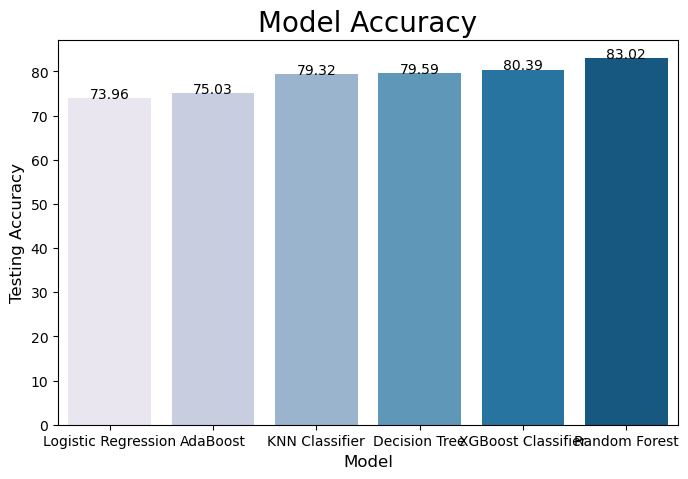

In [34]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(8,5))
p=sns.barplot(x='model', y='Test_accuracy', data=accuracy_scores_with_pca, palette='PuBu')
plt.title('Model Accuracy', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Testing Accuracy', fontsize = 12)
for index, row in accuracy_scores_with_pca.iterrows():
    p.text(x=row.name, y=row.Test_accuracy, s=round(row.Test_accuracy,2), color='black', horizontalalignment='center');

## 3.8. Calibration curve

In [117]:
# On logistic regression
calibration_logreg = CalibratedClassifierCV(logreg, cv = 3)
calibration_logreg.fit(X,y)
y_pred_logreg_calib = calibration_logreg.predict_proba(X)[::,1]
logreg_y, logreg_x = calibration_curve(y, y_pred_logreg_calib)

# On XGboost
calibration_xgb = CalibratedClassifierCV(xgb, cv = 3)
calibration_xgb.fit(X,y)
y_pred_xgb_calib = calibration_xgb.predict_proba(X)[::,1]
xgb_y, xgb_x = calibration_curve(y, y_pred_xgb_calib)

# On KNN
calibration_knn = CalibratedClassifierCV(knn, cv = 3)
calibration_knn.fit(X,y)
y_pred_knn_calib = calibration_knn.predict_proba(X)[::,1]
knn_y, knn_x = calibration_curve(y, y_pred_knn_calib)

# On Random forest
calibration_rf = CalibratedClassifierCV(rf, cv = 3)
calibration_rf.fit(X,y)
y_pred_rf_calib = calibration_rf.predict_proba(X)[::,1]
rf_y,rf_x = calibration_curve(y, y_pred_rf_calib)


CalibratedClassifierCV(base_estimator=LogisticRegression(random_state=42,
                                                         solver='newton-cg'),
                       cv=3)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    enable_categorical=False,
                                                    eta=0.4,
                                                    eval_metric='logloss',
                                                    gamma=0, gpu_id=-1,
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.5,
                                                    max_delta_step=0,
                                                    max_depth=6,

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=3), cv=3)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20,
                                                             random_state=42),
                       cv=3)

Text(0.5, 0.98, 'Calibration plot')

Text(0.5, 0, 'Predicted probability')

Text(0, 0.5, 'True probability in each bin')

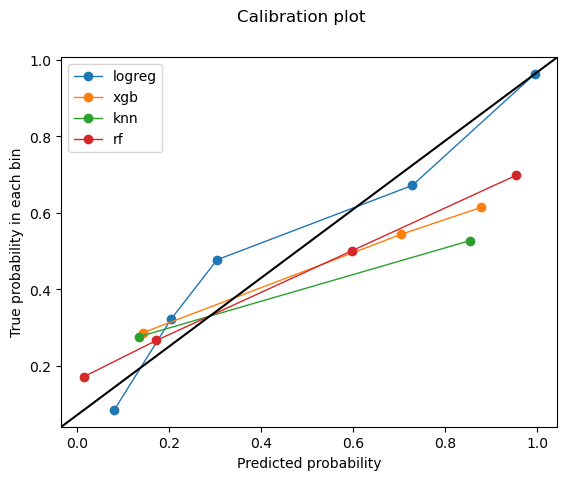

In [118]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_y, logreg_x, marker='o', linewidth=1, label='logreg')
plt.plot(xgb_y,xgb_x, marker='o', linewidth=1, label='xgb')
plt.plot(knn_y,knn_x, marker='o', linewidth=1, label='knn')
plt.plot(rf_y,rf_x, marker='o', linewidth=1, label='rf')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

### 3.9. Confusion matrix

Text(0.5, 1.0, 'Random forest Confusion Matrix')

Text(0.5, 23.52222222222222, '\nPredicted Values')

Text(50.722222222222214, 0.5, 'Actual Values ')

[Text(0.5, 0, 'Predicted_not_cancelled'), Text(1.5, 0, 'Predicted_cancelled')]

[Text(0, 0.5, 'Actual_not_cancelled'), Text(0, 1.5, 'Actual_cancelled')]

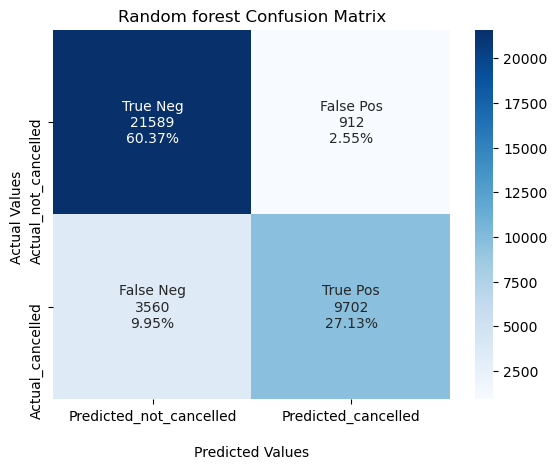

In [120]:
# Random forest
cf_matrix_rf = confusion_matrix(test_y, y_pred_rf)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_rf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_rf.flatten()/np.sum(cf_matrix_rf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_rf, annot=labels, fmt='', cmap='Blues')

ax.set_title('Random forest Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Predicted_not_cancelled','Predicted_cancelled'])
ax.yaxis.set_ticklabels(['Actual_not_cancelled','Actual_cancelled'])

## Display the visualization of the Confusion Matrix.
plt.show()

Text(0.5, 1.0, 'XGBoost Confusion Matrix')

Text(0.5, 23.52222222222222, '\nPredicted Values')

Text(50.722222222222214, 0.5, 'Actual Values ')

[Text(0.5, 0, 'Predicted_not_cancelled'), Text(1.5, 0, 'Predicted_cancelled')]

[Text(0, 0.5, 'Actual_not_cancelled'), Text(0, 1.5, 'Actual_cancelled')]

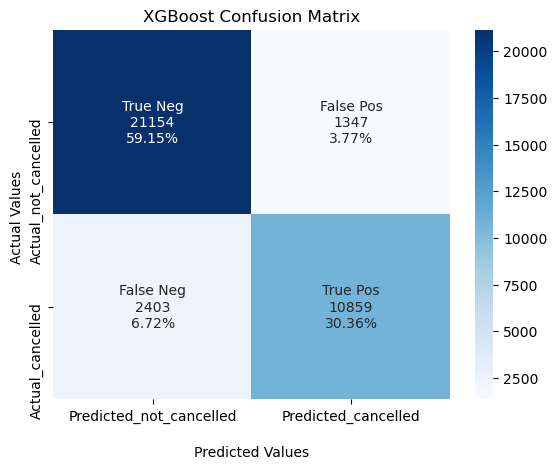

In [121]:
# XGBoost
cf_matrix_xgb = confusion_matrix(test_y, y_pred_xgb)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_xgb.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_xgb.flatten()/np.sum(cf_matrix_xgb)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_xgb, annot=labels, fmt='', cmap='Blues')

ax.set_title('XGBoost Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Predicted_not_cancelled','Predicted_cancelled'])
ax.yaxis.set_ticklabels(['Actual_not_cancelled','Actual_cancelled'])

## Display the visualization of the Confusion Matrix.
plt.show()

Text(0.5, 1.0, 'KNN Confusion Matrix')

Text(0.5, 23.52222222222222, '\nPredicted Values')

Text(50.722222222222214, 0.5, 'Actual Values ')

[Text(0.5, 0, 'Predicted_not_cancelled'), Text(1.5, 0, 'Predicted_cancelled')]

[Text(0, 0.5, 'Actual_not_cancelled'), Text(0, 1.5, 'Actual_cancelled')]

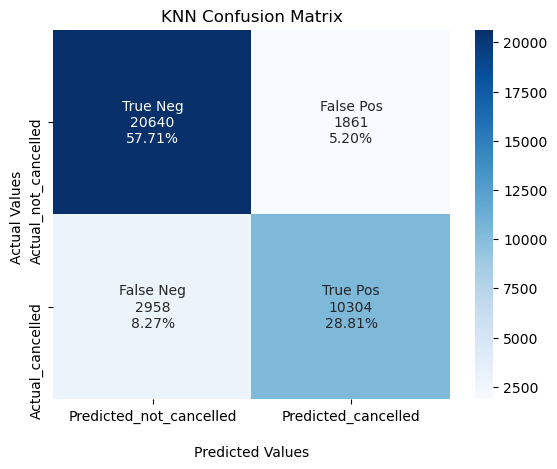

In [122]:
# KNN
cf_matrix_knn = confusion_matrix(test_y, y_pred_knn)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_knn.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_knn.flatten()/np.sum(cf_matrix_knn)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_knn, annot=labels, fmt='', cmap='Blues')

ax.set_title('KNN Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Predicted_not_cancelled','Predicted_cancelled'])
ax.yaxis.set_ticklabels(['Actual_not_cancelled','Actual_cancelled'])

## Display the visualization of the Confusion Matrix.
plt.show()

Text(0.5, 1.0, 'Logistic regression Confusion Matrix')

Text(0.5, 23.52222222222222, '\nPredicted Values')

Text(50.722222222222214, 0.5, 'Actual Values ')

[Text(0.5, 0, 'Predicted_not_cancelled'), Text(1.5, 0, 'Predicted_cancelled')]

[Text(0, 0.5, 'Actual_not_cancelled'), Text(0, 1.5, 'Actual_cancelled')]

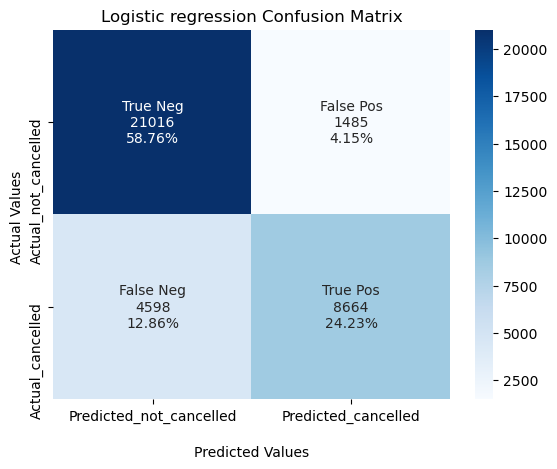

In [123]:
# Logistic regression
cf_matrix_logreg = confusion_matrix(test_y, y_pred_log)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_logreg.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_logreg.flatten()/np.sum(cf_matrix_logreg)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_logreg, annot=labels, fmt='', cmap='Blues')

ax.set_title('Logistic regression Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Predicted_not_cancelled','Predicted_cancelled'])
ax.yaxis.set_ticklabels(['Actual_not_cancelled','Actual_cancelled'])

## Display the visualization of the Confusion Matrix.
plt.show()

## 4. Causal model

In [8]:
df_causal = raw_data.copy()

# Data preprocessing

#f eature engineering
df_causal['total_stay'] = df_causal['stays_in_week_nights']+df_causal['stays_in_weekend_nights']
df_causal['guests'] = df_causal['adults']+df_causal['children'] +df_causal['babies']
df_causal['different_room_assigned']=0
slice_indices =df_causal['reserved_room_type']!=df_causal['assigned_room_type']
df_causal.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
df_causal = df_causal.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
df_causal = df_causal.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
df_causal['country']= df_causal['country'].fillna(df_causal['country'].mode()[0])
df_causal = df_causal.drop(['arrival_date_year','distribution_channel','reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
df_causal['different_room_assigned']= df_causal['different_room_assigned'].replace(1,True)
df_causal['different_room_assigned']= df_causal['different_room_assigned'].replace(0,False)
df_causal['is_canceled']= df_causal['is_canceled'].replace(1,True)
df_causal['is_canceled']= df_causal['is_canceled'].replace(0,False)

df_causal.dropna(inplace=True)

In [9]:
## Step-1. Create a Causal Graph

causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->different_room_assigned; U->is_canceled;U->required_car_parking_spaces;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> is_canceled;
country->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
}"""

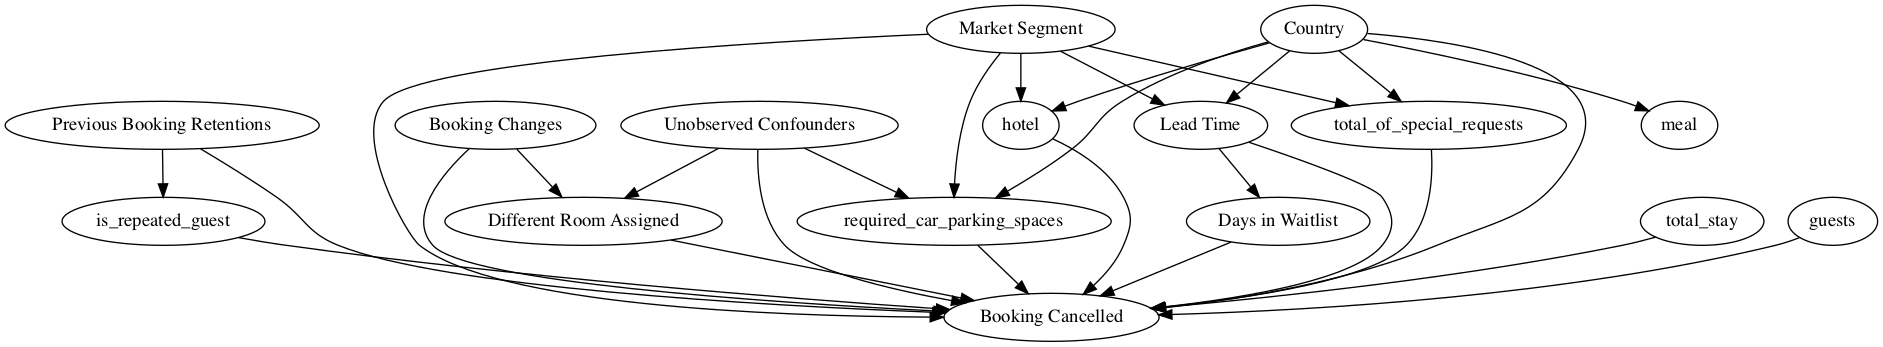

In [10]:
model= dowhy.CausalModel(
        data = df_causal,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()


display(Image(filename="causal_model.png"))

In [11]:
## Step-2. Identify the Causal Effect

model= dowhy.CausalModel(
        data = df_causal,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|hotel,country,previous_book
d[different_room_assigned]                                                    

                                                                              
ings_not_canceled,total_of_special_requests,required_car_parking_spaces,guests
                                                                              

                                                                              
,market_segment,meal,days_in_waiting_list,lead_time,total_stay,is_repeated_gue
                                                                              

                    
st,booking_changes))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_ass

In [12]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|hotel,country,previous_book
d[different_room_assigned]                                                    

                                                                              
ings_not_canceled,total_of_special_requests,required_car_parking_spaces,guests
                                                                              

                                                                              
,market_segment,meal,days_in_waiting_list,lead_time,total_stay,is_repeated_gue
                                                                              

                    
st,booking_changes))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→i

In [13]:
# Having a different room assigned decreases the chances of a cancellation

## 5. Counterfactuals

In [ ]:
df_c = raw_data[['is_canceled', 'lead_time','market_segment',
                 'customer_type','deposit_type']]

In [ ]:
df_c.head()

is_canceled  lead_time market_segment customer_type deposit_type
0            0        342         Direct     Transient   No Deposit
1            0        737         Direct     Transient   No Deposit
2            0          7         Direct     Transient   No Deposit
3            0         13      Corporate     Transient   No Deposit
4            0         14      Online TA     Transient   No Deposit

In [ ]:
for col in ['market_segment','customer_type','deposit_type']:
    encoded = pd.get_dummies(df_c[col],prefix = str(col), drop_first=True)
    df_c = df_c.join(encoded)
    df_c = df_c.drop(col, axis=1)
df_c.head(5)

is_canceled  lead_time  market_segment_Complementary  \
0            0        342                             0   
1            0        737                             0   
2            0          7                             0   
3            0         13                             0   
4            0         14                             0   

   market_segment_Corporate  market_segment_Direct  market_segment_Groups  \
0                         0                      1                      0   
1                         0                      1                      0   
2                         0                      1                      0   
3                         1                      0                      0   
4                         0                      0                      0   

   market_segment_Offline TA/TO  market_segment_Online TA  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         1   

   market_segment_Undefined  customer_type_Group  customer_type_Transient  \
0                         0                    0                        1   
1                         0                    0                        1   
2                         0                    0                        1   
3                         0                    0                        1   
4                         0                    0                        1   

   customer_type_Transient-Party  deposit_type_Non Refund  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   deposit_type_Refundable  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

In [ ]:
## Splitting the data into dependent and independent variables first
X = df_c.drop('is_canceled', axis = 1)
y = df_c['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dataset = X.copy()
dataset['outcome'] = y
backend = 'sklearn'

In [ ]:
## train model
d = dice_ml.Data(dataframe=dataset, continuous_features=['lead_time'], outcome_name='outcome')
clf = DecisionTreeClassifier(max_depth = 15)
m = dice_ml.Model(model=clf.fit(X_train, y_train), backend=backend) 
exp_random = dice_ml.Dice(d, m, method='random')

In [ ]:
## query an instance
query_instances = X_test.iloc[[0]]
query_instances

lead_time  market_segment_Complementary  market_segment_Corporate  \
30946        203                             0                         0   

       market_segment_Direct  market_segment_Groups  \
30946                      1                      0   

       market_segment_Offline TA/TO  market_segment_Online TA  \
30946                             0                         0   

       market_segment_Undefined  customer_type_Group  customer_type_Transient  \
30946                         0                    0                        1   

       customer_type_Transient-Party  deposit_type_Non Refund  \
30946                              0                        0   

       deposit_type_Refundable  
30946                        0

In [ ]:
# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=5, desired_class="opposite", verbose=False)
# Visualize counterfactual explanation
dice_exp_random.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

Query instance (original outcome : 0)


lead_time  market_segment_Complementary  market_segment_Corporate  \
0        203                             0                         0   

   market_segment_Direct  market_segment_Groups  market_segment_Offline TA/TO  \
0                      1                      0                             0   

   market_segment_Online TA  market_segment_Undefined  customer_type_Group  \
0                         0                         0                    0   

   customer_type_Transient  customer_type_Transient-Party  \
0                        1                              0   

   deposit_type_Non Refund  deposit_type_Refundable  outcome  
0                        0                        0        0


Diverse Counterfactual set (new outcome: 1.0)


lead_time  market_segment_Complementary  market_segment_Corporate  \
0        203                             0                         0   
1        473                             0                         0   
2        203                             0                         1   
3        503                             0                         0   
4        536                             0                         0   

   market_segment_Direct  market_segment_Groups  market_segment_Offline TA/TO  \
0                      1                      0                             0   
1                      1                      0                             0   
2                      1                      0                             0   
3                      1                      0                             0   
4                      1                      0                             0   

   market_segment_Online TA  market_segment_Undefined  customer_type_Group  \
0                         0                         0                    1   
1                         0                         1                    0   
2                         0                         0                    0   
3                         0                         0                    0   
4                         0                         0                    0   

   customer_type_Transient  customer_type_Transient-Party  \
0                        0                              0   
1                        1                              0   
2                        0                              0   
3                        1                              0   
4                        1                              0   

   deposit_type_Non Refund  deposit_type_Refundable  outcome  
0                        0                        0        1  
1                        0                        0        1  
2                        0                        0        1  
3                        0                        0        1  
4                        0                        0        1

In [147]:
## query an instance
query_instances = X_train.iloc[[15]]
query_instances

lead_time  market_segment_Complementary  market_segment_Corporate  \
67118        285                             0                         0   

       market_segment_Direct  market_segment_Groups  \
67118                      0                      0   

       market_segment_Offline TA/TO  market_segment_Online TA  \
67118                             0                         1   

       market_segment_Undefined  customer_type_Group  customer_type_Transient  \
67118                         0                    0                        1   

       customer_type_Transient-Party  deposit_type_Non Refund  \
67118                              0                        0   

       deposit_type_Refundable  
67118                        0

In [148]:
# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=5, desired_class="opposite", verbose=False)
# Visualize counterfactual explanation
dice_exp_random.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

Query instance (original outcome : 1)


lead_time  market_segment_Complementary  market_segment_Corporate  \
0        285                             0                         0   

   market_segment_Direct  market_segment_Groups  market_segment_Offline TA/TO  \
0                      0                      0                             0   

   market_segment_Online TA  market_segment_Undefined  customer_type_Group  \
0                         1                         0                    0   

   customer_type_Transient  customer_type_Transient-Party  \
0                        1                              0   

   deposit_type_Non Refund  deposit_type_Refundable  outcome  
0                        0                        0        1


Diverse Counterfactual set (new outcome: 0.0)


lead_time  market_segment_Complementary  market_segment_Corporate  \
0          7                             0                         0   
1         91                             0                         0   
2          5                             0                         0   
3        189                             0                         0   
4        236                             0                         0   

   market_segment_Direct  market_segment_Groups  market_segment_Offline TA/TO  \
0                      0                      0                             0   
1                      0                      0                             0   
2                      0                      0                             0   
3                      0                      0                             0   
4                      1                      0                             0   

   market_segment_Online TA  market_segment_Undefined  customer_type_Group  \
0                         1                         0                    0   
1                         1                         0                    0   
2                         1                         0                    0   
3                         1                         0                    0   
4                         1                         0                    0   

   customer_type_Transient  customer_type_Transient-Party  \
0                        1                              0   
1                        1                              0   
2                        1                              0   
3                        1                              0   
4                        1                              0   

   deposit_type_Non Refund  deposit_type_Refundable  outcome  
0                        0                        1        0  
1                        0                        0        0  
2                        0                        0        0  
3                        0                        0        0  
4                        0                        0        0

## 6. Customer segmentation

https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086

K-means clusters data using euclidean distance. Meanwhile, K-modes clusters categorical data based off the number of matching categories between data points. A mixture of both of these: the K-prototype algorithm, is just what we need to cluster.

### 6.1. KMeans

In [124]:
df.head(5)

hotel  is_canceled  lead_time  stays_in_weekend_nights  \
0      0            0    1.59531                 -1.07621   
1      0            0    2.60640                 -1.07621   
2      0            0   -1.17639                 -1.07621   
3      0            0   -0.92226                 -1.07621   
4      0            0   -0.88812                 -1.07621   

   stays_in_week_nights   adults  children   babies  is_repeated_guest  \
0              -2.19306  0.32154  -0.27866 -0.08805                  0   
1              -2.19306  0.32154  -0.27866 -0.08805                  0   
2              -0.87764 -1.77579  -0.27866 -0.08805                  0   
3              -0.87764 -1.77579  -0.27866 -0.08805                  0   
4              -0.07818  0.32154  -0.27866 -0.08805                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                -0.23974                        -0.17679          2.38285   
1                -0.23974                        -0.17679          2.38291   
2                -0.23974                        -0.17679         -0.42142   
3                -0.23974                        -0.17679         -0.42142   
4                -0.23974                        -0.17679         -0.42142   

   days_in_waiting_list      adr  required_car_parking_spaces  \
0              -0.17880 -3.20949                     -0.25743   
1              -0.17880 -3.20949                     -0.25743   
2              -0.17880 -0.48784                     -0.25743   
3              -0.17880 -0.48784                     -0.25743   
4              -0.17880  0.01624                     -0.25743   

   total_of_special_requests  total_guest  total_night  meal_FB  meal_HB  \
0                   -0.82633      0.15848     -3.32423        0        0   
1                   -0.82633      0.15848     -3.32423        0        0   
2                   -0.82633     -1.72192     -1.47171        0        0   
3                   -0.82633     -1.72192     -1.47171        0        0   
4                    1.02714      0.15848     -0.52025        0        0   

   meal_SC  market_segment_Complementary  market_segment_Corporate  \
0        0                             0                         0   
1        0                             0                         0   
2        0                             0                         0   
3        0                             0                         1   
4        0                             0                         0   

   market_segment_Direct  market_segment_Groups  market_segment_Offline TA/TO  \
0                      1                      0                             0   
1                      1                      0                             0   
2                      1                      0                             0   
3                      0                      0                             0   
4                      0                      0                             0   

   market_segment_Online TA  market_segment_Undefined  reserved_room_type_B  \
0                         0                         0                     0   
1                         0                         0                     0   
2                         0                         0                     0   
3                         0                         0                     0   
4                         1                         0                     0   

   reserved_room_type_C  reserved_room_type_D  reserved_room_type_E  \
0                     1                     0                     0   
1                     1                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   reserved_room_type_F  reserved_room_type_G  reserved_room_typ

In [125]:
df_seg = df.copy()
df_seg = df_seg.drop(['total_guest','total_night'], axis = 1)

In [129]:
pca = PCA(3)
 
#Transform the data
df_seg1 = pca.fit_transform(df_seg)

In [157]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df_seg1)
    kmeanModel.fit(df_seg1)
 
    distortions.append(sum(np.min(cdist(df_seg1, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df_seg1.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(df_seg1, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / df_seg1.shape[0]
    mapping2[k] = kmeanModel.inertia_

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

Text(0.5, 0, 'Values of K')

Text(0, 0.5, 'Inertia')

Text(0.5, 1.0, 'The Elbow Method using Inertia')

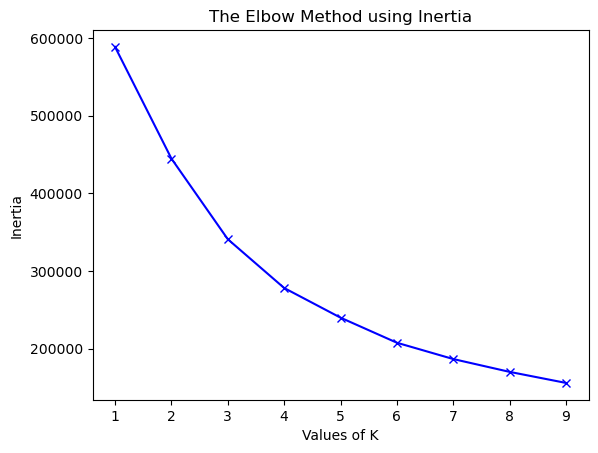

In [133]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

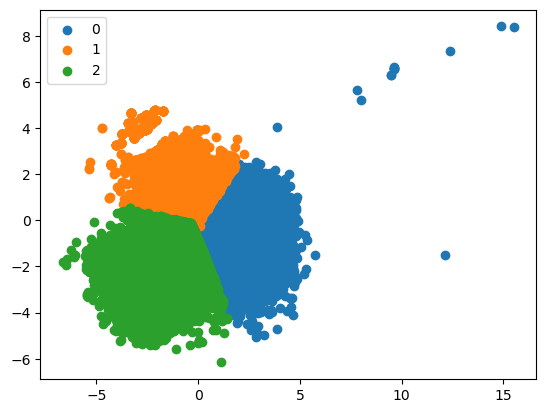

In [134]:
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df_seg1)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df_seg1[label == i , 0] , df_seg1[label == i , 1] , label = i)
plt.legend()
plt.show()

### K-prototypes

In [29]:
df_main.head(5)

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2   0.00000       0   
1                        0                     0       2   0.00000       0   
2                        0                     1       1   0.00000       0   
3                        0                     1       1   0.00000       0   
4                        0                     2       2   0.00000       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
0   BB     PRT         Direct               Direct                  0   
1   BB     PRT         Direct               Direct                  0   
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  C   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type     agent  company  \
0                  C                3   No Deposit   0.00000  0.00000   
1                  C                4   No Deposit   0.00000  0.00000   
2                  C                0   No Deposit   0.00000  0.00000   
3                  A                0   No Deposit 304.00000  0.00000   
4                  A                0   No Deposit 240.00000  0.00000   

   days_in_waiting_list customer_type      adr  required_car_parking_spaces  \
0                     0     Transient  0.00000                            0   
1                     0     Transient  0.00000                            0   
2                     0     Transient 75.00000                            0   
3                     0     Transient 75.00000                            0   
4                     0     Transient 98.00000                            0   

   total_of_special_requests reservation_status reservation_status_date  \
0                          0          Check-Out              2015-07-01   
1                          0          Check-Out              2015-07-01   
2                          0          Check-Out              2015-07-02   
3                          0          Check-Out              2015-07-02   
4                          1          Check-Out              2015-07-03   

   same_room  total_guest  total_night  
0       True      2.00000            0  
1       True      2.00000            0  
2      False      1.00000            1  
3       True      1.00000            1  
4       True      2.00000            2

In [30]:
df_new_seg = df_main.copy()
df_new_seg['hotel'] = convert_to_binary(df_new_seg['hotel'])

In [31]:
df_new_seg.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'same_room',
       'total_guest', 'total_night'],
      dtype='object')

In [32]:
df_new_seg = df_new_seg.drop(columns=['is_canceled', 'agent', 'company', 'country', 'reservation_status',
                                      'reservation_status_date','same_room','total_guest', 'total_night'])

In [33]:
df_new_seg.head()

hotel  lead_time  arrival_date_year arrival_date_month  \
0      0        342               2015               July   
1      0        737               2015               July   
2      0          7               2015               July   
3      0         13               2015               July   
4      0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2   0.00000       0   
1                        0                     0       2   0.00000       0   
2                        0                     1       1   0.00000       0   
3                        0                     1       1   0.00000       0   
4                        0                     2       2   0.00000       0   

  meal market_segment distribution_channel  is_repeated_guest  \
0   BB         Direct               Direct                  0   
1   BB         Direct               Direct                  0   
2   BB         Direct               Direct                  0   
3   BB      Corporate            Corporate                  0   
4   BB      Online TA                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  C   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type  days_in_waiting_list  \
0                  C                3   No Deposit                     0   
1                  C                4   No Deposit                     0   
2                  C                0   No Deposit                     0   
3                  A                0   No Deposit                     0   
4                  A                0   No Deposit                     0   

  customer_type      adr  required_car_parking_spaces  \
0     Transient  0.00000                            0   
1     Transient  0.00000                            0   
2     Transient 75.00000                            0   
3     Transient 75.00000                            0   
4     Transient 98.00000                            0   

   total_of_special_requests  
0                          0  
1                          0  
2                          0  
3                          0  
4                          1

In [34]:
df_new_seg['children'] = df_new_seg['children'].astype('int64')

In [144]:
#dataframe to an array
smart_array = df_new_seg.values

In [36]:
#converting numerical columns datatype as float
#smart_array[:, 0] = smart_array[:,0].astype(float)
#smart_array[:, 1] = smart_array[:,1].astype(float)
#smart_array[:, 2] = smart_array[:,2].astype(float)
#smart_array[:, 4] = smart_array[:,4].astype(float)
#smart_array[:, 5] = smart_array[:,5].astype(float)
#smart_array[:, 6] = smart_array[:,6].astype(float)
#smart_array[:, 7] = smart_array[:,7].astype(float)
#smart_array[:, 8] = smart_array[:,8].astype(float)
#smart_array[:, 10] = smart_array[:,10].astype(float)
#smart_array[:, 14] = smart_array[:,14].astype(float)
#smart_array[:, 15] = smart_array[:,15].astype(float)
#smart_array[:, 16] = smart_array[:,16].astype(float)
#smart_array[:, 19] = smart_array[:,19].astype(float)
#smart_array[:, 21] = smart_array[:,21].astype(float)
#smart_array[:, 24] = smart_array[:,24].astype(float)
#smart_array[:, 25] = smart_array[:,25].astype(float)

#index of categorical columns
categorical_index = list(range(3,4)) + list(range(11,14)) + list(range(17, 19)) + list(range(20, 21)) + list(range(22, 23))


In [161]:
#def plot_elbow_curve(start, end, data):
#    no_of_clusters = list(range(start, end+1))
#    cost_values = []
    
#    for k in no_of_clusters:
#        test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
#        test_model.fit_predict(df_new_seg, categorical=categorical_index)
#        cost_values.append(test_model.cost_)
        
#    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
#    plt.figure(figsize=(15, 7))
#    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
#    ax.set_title('Elbow curve', fontsize=18)
#    ax.set_xlabel('No of clusters', fontsize=14)
#    ax.set_ylabel('Cost', fontsize=14)
#    ax.set(xlim=(start-0.1, end+0.1))
#    plt.plot();
    
# Plotting elbow curve for k=3 to k=8
#plot_elbow_curve(3,8,smart_array)

In [37]:
cost_values = []
for n in range(3, 7):
    kproto = KPrototypes(n_clusters=n, init='Huang', verbose=0, random_state=42, n_jobs=-1) 
    clusters = kproto.fit_predict(df_new_seg, categorical=categorical_index)
    cost_values.append((n, kproto.cost_))
    
    print(f'cost: {kproto.cost_}')

cost: 626903424.2675039
cost: 502724024.67557514
cost: 438916237.95489323
cost: 392802390.39163435


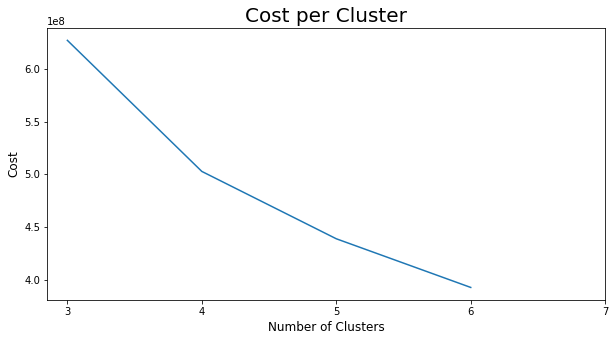

In [38]:
# Creating a dataframe for our K-Prototypes clusters: 
cost_values_df = pd.DataFrame(cost_values, columns=['n', 'cost'])

# Visualizing the K-prototype costs:
plt.figure(figsize=(10,5))
plt.plot(cost_values_df['n'], cost_values_df['cost'])
plt.xticks([3,4,5,6,7])
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Cost', size=12)
plt.title('Cost per Cluster', size=20);

In [40]:
# From the elbow plot, we can consider 4 clusters:
kproto_4 = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=42, n_jobs=-1)
clusters = kproto_4.fit_predict(df_new_seg, categorical=categorical_index)                                                        
print(f'cost: {kproto_4.cost_}')

cost: 502724024.67557514


In [44]:
# Adding the clusters values in the dataset:
df_new_seg['clusters'] = clusters
df_new_seg.to_csv("cluster_total.csv")

__Conclusion:__
Based on the four clusters, we have the following inference:
<br>
Cluster 0:
* Second highest cancellation(45%)
* Peak month: July
* Higher average weekend and week night stay
* Second highest average lead time(161)
* Second highest average daily rate
<br>

Looking at the lead time, we can infer that these customers *plan ahead and stay longer*

Cluster 1:
* Lowest cancellation(25%)
* Highest number of repeat guests
* Highest weekend and weeknight stay
* Lowest previous booking not cancelled
* Lowest lead time(31)
* Peak month: March
<br>

Looking at the lead time and repeat guests, we can infer that these customers are *do not plan ahead and visit more frequently*

Cluster 2:
* Low cancellation(35%)
* Highest number of children and babies	
* Highest average daily rate	
* Peak month: August	
* Lowest previous cancellation	
* Lowest average days in waiting list(0.11)
* Low lead time(43)
* Highest average total special requests and required car parking space
<br>

Clearly, these are the *family customers*. They have highest children and higher average special requests.

Cluster 3:
* Highest cancellation(64%) 
* Highest mean lead time(326)
* Highest number of previous cancellations
* Lowest number of previous bookings not cancelled
* Peak month: September
* Highest average days in waiting list(9)
<br>

As per the lead time, these customers *plan way ahead* and have the *highest probability to cancel*.

